In [1]:
import torch 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# =====================
# 1. Install dependencies (uncomment if needed)
# =====================
# !pip install transformers datasets scikit-learn matplotlib torch

# =====================
# 2. Imports
# =====================
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from torch.optim import AdamW
from tqdm import tqdm
import matplotlib.pyplot as plt

In [12]:
# =====================
# 3. Load Data
# =====================
df = pd.read_csv("C:\\Users\\yalav\\OneDrive\\Documents\\python\\project\\strictly_balanced_top10_cleaned.csv")
genre_columns = ['Drama', 'Comedy', 'Romance', 'Thriller', 'Action',
                 'Horror', 'Documentary', 'Animation', 'Music', 'Crime']

texts = df['clean_overview'].tolist()
labels = df[genre_columns].values.astype(np.float32)
df.head()
# Make sure 'clean_overview' exists and contains only valid strings
df = df[df['clean_overview'].notna()]
texts = df['clean_overview'].astype(str).tolist()
df.head()

,id,genres,overview,poster_path,keywords,Action,Adventure,Animation,Comedy,Crime,...,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,poster_url,clean_overview
0,27205,"['Action', 'Science Fiction', 'Adventure']","Cobb, a skilled thief who commits corporate es...",/oYuLEt3zVCKq57qu2F8dT7NIa6f.jpg,"rescue, mission, dream, airplane, paris, franc...",1,1,0,0,0,...,0,0,0,1,0,0,0,0,https://image.tmdb.org/t/p/w500/oYuLEt3zVCKq57...,cobb skilled thief commits corporate espionage...
1,157336,"['Adventure', 'Drama', 'Science Fiction']",The adventures of a group of explorers who mak...,/gEU2QniE6E77NI6lCU6MxlNBvIx.jpg,"rescue, future, spacecraft, race against time,...",0,1,0,0,0,...,0,0,0,1,0,0,0,0,https://image.tmdb.org/t/p/w500/gEU2QniE6E77NI...,adventure group explorer make use newly discov...
2,155,"['Drama', 'Action', 'Crime', 'Thriller']",Batman raises the stakes in his war on crime. ...,/qJ2tW6WMUDux911r6m7haRef0WH.jpg,"joker, sadism, chaos, secret identity, crime f...",1,0,0,0,1,...,0,0,0,0,0,1,0,0,https://image.tmdb.org/t/p/w500/qJ2tW6WMUDux91...,batman raise stake war crime help lt jim gordo...
3,19995,"['Action', 'Adventure', 'Fantasy', 'Science Fi...","In the 22nd century, a paraplegic Marine is di...",/kyeqWdyUXW608qlYkRqosgbbJyK.jpg,"future, society, culture clash, space travel, ...",1,1,0,0,0,...,0,0,0,1,0,0,0,0,https://image.tmdb.org/t/p/w500/kyeqWdyUXW608q...,nd century paraplegic marine dispatched moon p...
4,24428,"['Science Fiction', 'Action', 'Adventure']",When an unexpected enemy emerges and threatens...,/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg,"new york city, superhero, shield, based on com...",1,1,0,0,0,...,0,0,0,1,0,0,0,0,https://image.tmdb.org/t/p/w500/RYMX2wcKCBAr24...,unexpected enemy emerges threatens global safe...


In [15]:
# =====================
# 4. Tokenize
# =====================
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

encodings = tokenizer(texts, truncation=True, padding=True, max_length=200)
input_ids = encodings['input_ids']
attention_masks = encodings['attention_mask']

In [16]:
# =====================
# 5. Dataset Class
# =====================
class MovieGenreDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx]),
            'attention_mask': torch.tensor(self.attention_masks[idx]),
            'labels': torch.tensor(self.labels[idx])
        }


In [23]:
# =====================
# 3. Split into Train/Val
# =====================
X_train, X_val, y_train, y_val = train_test_split(
    list(zip(input_ids, attention_masks)),
    labels,
    test_size=0.1,
    random_state=42
)

train_input_ids = [x[0] for x in X_train]
train_attention_masks = [x[1] for x in X_train]
val_input_ids = [x[0] for x in X_val]
val_attention_masks = [x[1] for x in X_val]

# =====================
# 4. Dataset Class
# =====================
class MovieGenreDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.float32)
        }

# =====================
# 5. Create DataLoaders
# =====================
train_dataset = MovieGenreDataset(train_input_ids, train_attention_masks, y_train)
val_dataset = MovieGenreDataset(val_input_ids, val_attention_masks, y_val)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

print(f"📦 Train samples: {len(train_dataset)}")
print(f"🧪 Validation samples: {len(val_dataset)}")

📦 Train samples: 100699
🧪 Validation samples: 11189


In [24]:
# =====================
# 7. Model Definition
# =====================
class BERTGenreClassifier(nn.Module):
    def __init__(self, num_labels=10):
        super(BERTGenreClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        return self.out(self.dropout(pooled_output))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = BERTGenreClassifier().to(device)

cuda


In [25]:
# =====================
# 8. Training Setup
# =====================
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.BCEWithLogitsLoss()

In [26]:
# =====================
# 9. Training Loop
# =====================
train_losses, val_losses, val_f1s = [], [], []

for epoch in range(3):
    model.train()
    running_loss = 0.0

    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())

    val_losses.append(val_loss / len(val_loader))
    y_pred = np.concatenate(all_preds) > 0.5
    y_true = np.concatenate(all_labels)
    f1 = f1_score(y_true, y_pred, average='micro')
    val_f1s.append(f1)

    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Micro-F1: {f1:.4f}")


100%|███████████████████████████████████████████████████████████████████████████████████████████| 6294/6294 [23:55<00:00,  4.39it/s]


Epoch 1, Train Loss: 0.2342, Val Loss: 0.2080, Val Micro-F1: 0.6427


100%|███████████████████████████████████████████████████████████████████████████████████████████| 6294/6294 [24:22<00:00,  4.30it/s]


Epoch 2, Train Loss: 0.1859, Val Loss: 0.2070, Val Micro-F1: 0.6443


100%|███████████████████████████████████████████████████████████████████████████████████████████| 6294/6294 [27:06<00:00,  3.87it/s]


Epoch 3, Train Loss: 0.1539, Val Loss: 0.2138, Val Micro-F1: 0.6593


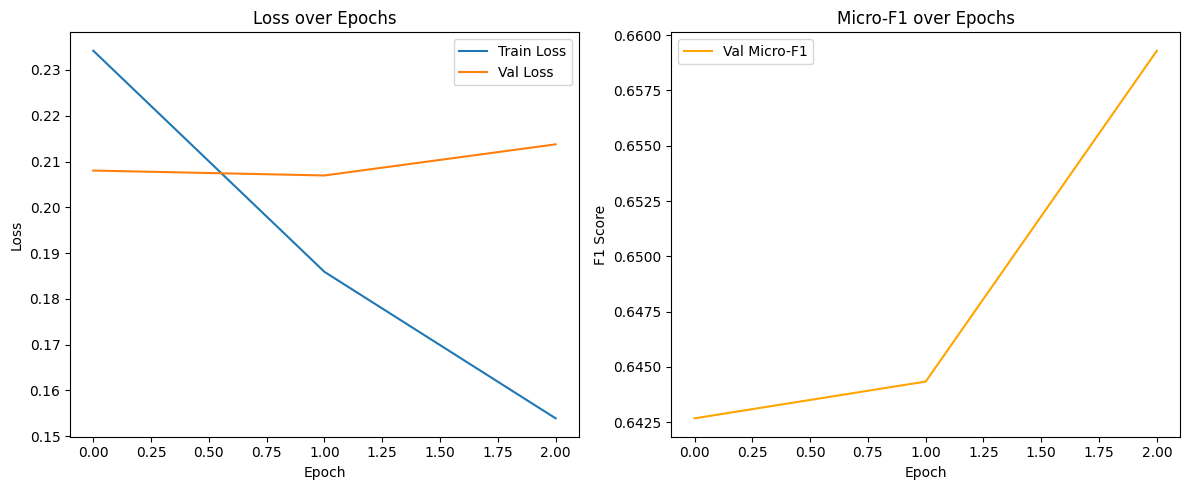

In [27]:
# =====================
# 10. Plot Curves
# =====================
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss over Epochs")

plt.subplot(1, 2, 2)
plt.plot(val_f1s, label='Val Micro-F1', color='orange')
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()
plt.title("Micro-F1 over Epochs")

plt.tight_layout()
plt.show()
